# Grayscale 3D CNN

In [ ]:
!pip install tensorflow_docs
!pip install mediapipe
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from utils import VideoDataset, validate_model, train_model, display_frames, display_learning_dynamic, classification_model_metrics

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

In [ ]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = ["слон", "пингвин", "кролик"]

min_frame_count = 25

lr = 0.0001
momentum = 0.0001
epoches = 15
save = True

annotations_file = "/content/drive/MyDrive/slovo/SLOVO_DATAFRAME.tsv" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv"
video_dir = "/content/drive/MyDrive/slovo/slovo" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo"

face_detection_model = '/content/face_detection_yunet_2023mar.onnx'

save_path = '/content/model'
model_name = 'ResNet_r3d_18_transferFE_Kinetics400'

In [ ]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,attachment_id,text,user_id,height,width,length,begin,end,group_rank,dataset
15412,6bd6120e-9896-48db-afb6-9e01713c6f25,слон,0a11105fbfa6d452b86187db53b753e2,636,360,107.0,9,84,20,test
15419,e61c12a9-f727-441d-86e8-a9b854decd3e,пингвин,3018b64d2c938f5b6a0826dfdf486f2c,640,360,165.0,32,111,19,test
15445,2eca9c1e-103c-4a23-98c8-1e994fe76762,пингвин,e0ca58d03fc73a305046edcdf7ef7492,360,640,109.0,18,65,20,test
15509,629fbfb5-0bdb-48f1-8456-b5d9a99a788f,кролик,e3e1fd4bbf07a0423ee20d5c9baa49cc,640,360,67.0,11,53,19,test
15516,bec3a934-5a5c-4604-8bcd-e973c85ed496,кролик,87fe0712fdd150ecc8d02cbbb2e047d6,640,360,132.0,24,87,20,test


In [ ]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 3. Example classes: ('пингвин', 'кролик', 'слон')


In [ ]:
classes.index('слон')

2

In [ ]:
train_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
test_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
val_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

train_dataloader = DataLoader(VideoDataset(video_labels, video_dir, IMG_SIZE, min_frame_count, classes, face_detection_model, ds_type = "train"), batch_size=train_batch_size, shuffle=True, **train_kwargs)
val_dataloader = DataLoader(VideoDataset(video_labels, video_dir, IMG_SIZE, min_frame_count, classes, face_detection_model, ds_type = "val"), batch_size=val_batch_size, shuffle=True, **val_kwargs)
test_dataloader = DataLoader(VideoDataset(video_labels, video_dir, IMG_SIZE, min_frame_count, classes, face_detection_model, ds_type = "test"), batch_size=test_batch_size, shuffle=True, **test_kwargs)

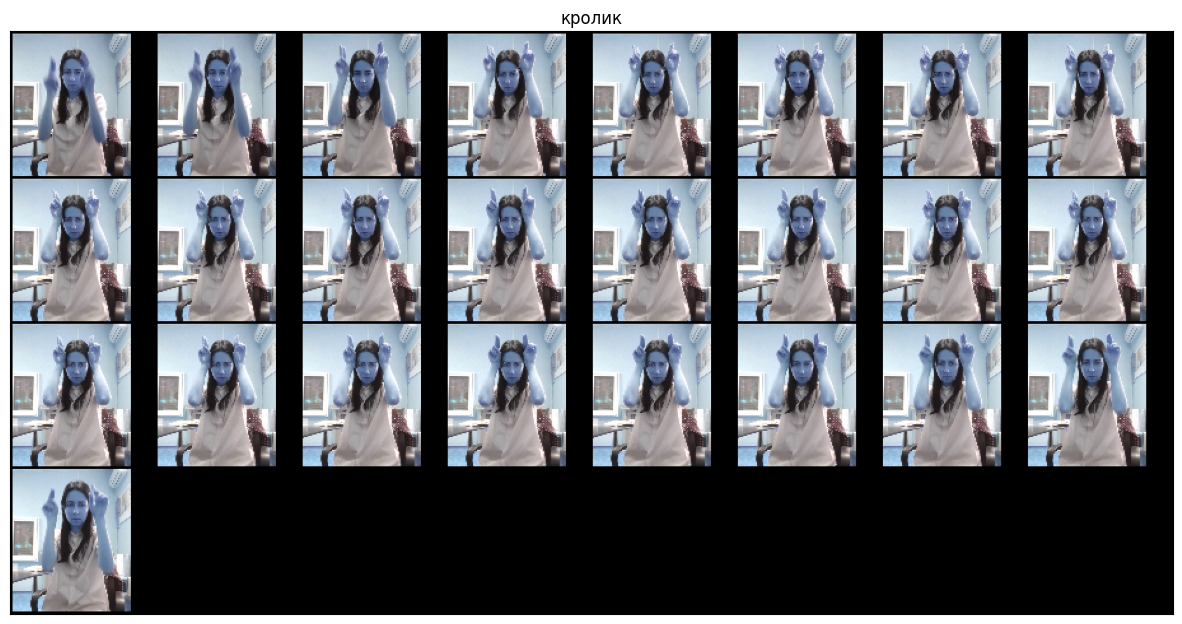

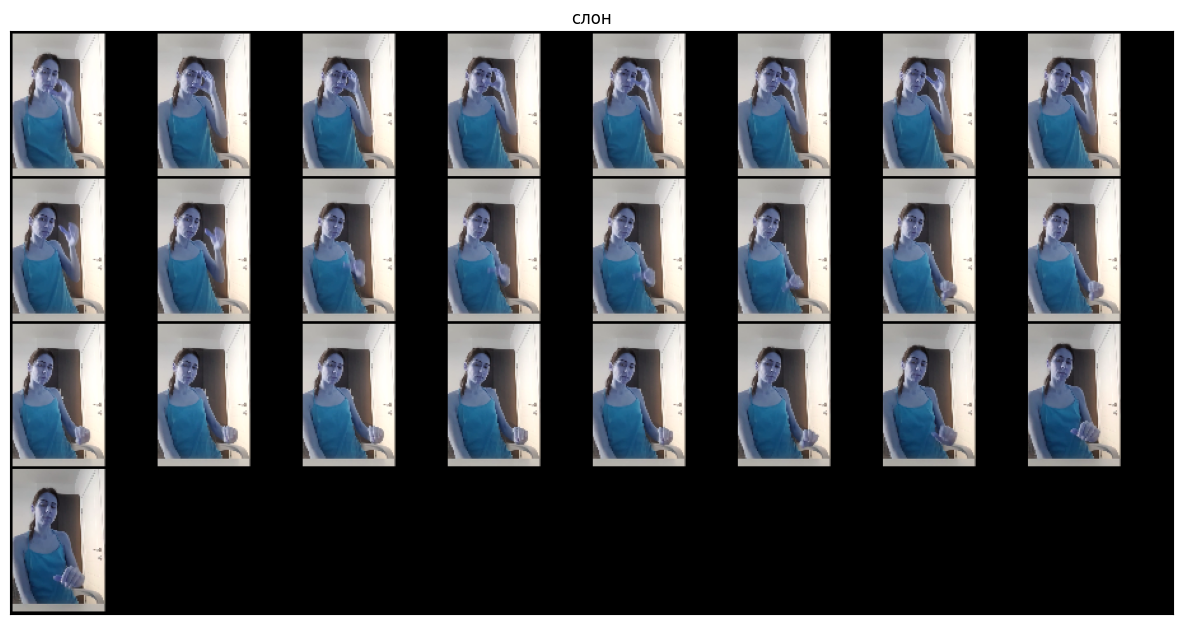

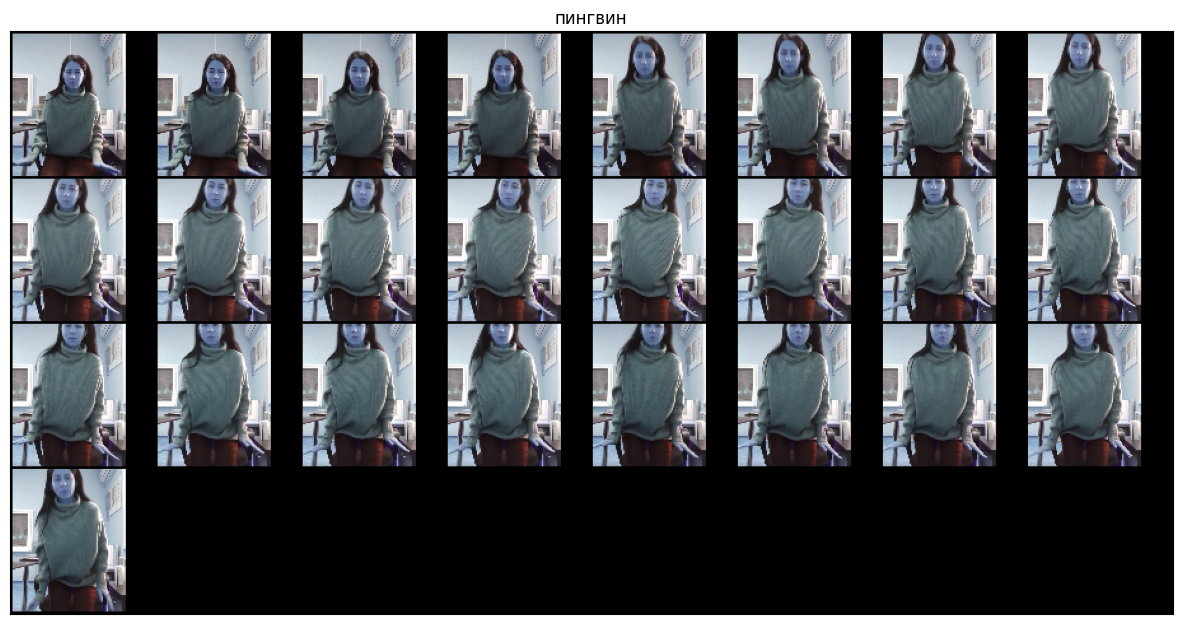

In [ ]:
display_frames(n_frames=3, dataloader=train_dataloader, classes=classes)

In [ ]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


In [ ]:
frames, labels = next(iter(test_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 224, 224])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([0])


In [ ]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class) # reset out features fir the last layer to the number of classes
resnet.fc

Linear(in_features=512, out_features=3, bias=True)

In [ ]:
print(resnet)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [ ]:
frames, labels = next(iter(test_dataloader))
frames = frames.to(device)
resnet.to(device)
print(f"Output shape: {resnet(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 3])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [ ]:
def check_some_predictions(n, model):
  test_dl = iter(test_dataloader)
  for i in range(n):
    frames, labels = next(test_dl)
    frames=frames.to(device)
    true_label = classes[labels.item()]
    output = model(frames/255)
    pred_label = classes[torch.argmax(output, 1)]
    print(f"Label: {true_label}; Predicted: {pred_label}")
check_some_predictions(4, resnet)

Label: кролик; Predicted: пингвин
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: пингвин
Label: пингвин; Predicted: пингвин


In [24]:
best_acc = 1/n_class
previous_epochs = 0
if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    check_some_predictions(4, resnet)

Train Epoch 1/15: train_loss=0.5826; val acc=0.833
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: кролик
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Train Epoch 2/15: train_loss=0.5646; val acc=0.833
Label: пингвин; Predicted: пингвин
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: слон
Label: кролик; Predicted: кролик
Train Epoch 3/15: train_loss=0.5504; val acc=1.000
Label: слон; Predicted: слон
Label: слон; Predicted: кролик
Label: кролик; Predicted: кролик
Label: кролик; Predicted: кролик
Train Epoch 4/15: train_loss=0.5272; val acc=1.000
Label: кролик; Predicted: кролик
Label: слон; Predicted: кролик
Label: кролик; Predicted: кролик
Label: слон; Predicted: слон
Train Epoch 5/15: train_loss=0.5096; val acc=1.000
Label: пингвин; Predicted: пингвин
Label: слон; Predicted: кролик
Label: слон; Predicted: слон
Label: пингвин; Predicted: пингвин
Train Epoch 6/15: train_loss=0.4964; val acc=1.000
Label: кролик; Predicted: кролик
Label: пингвин; P

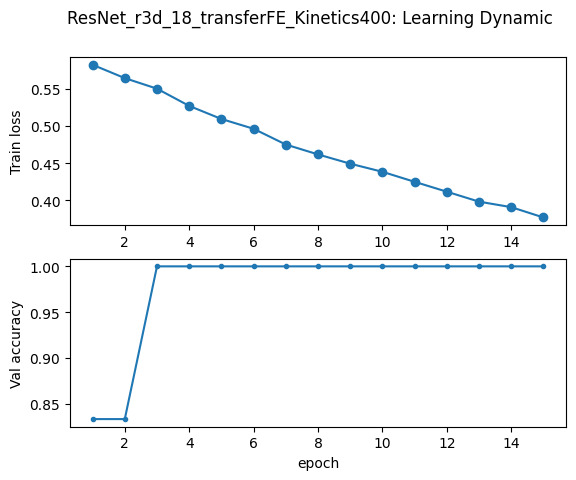

In [25]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

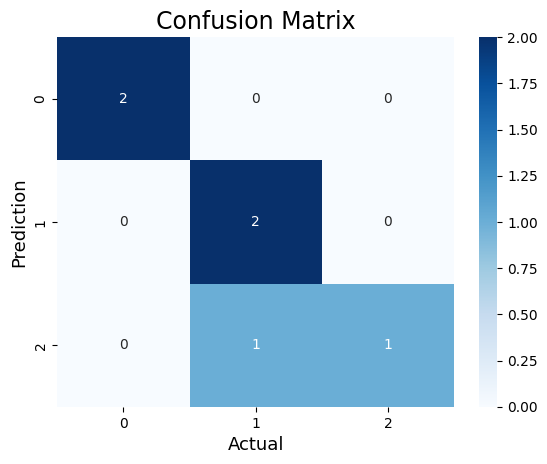

Accuracy=0.8333333333333334; Precision=0.8888888888888888; Recall=0.8333333333333334; F1=0.8602150537634408


In [26]:
classification_model_metrics(resnet, classes, test_dataloader, device)

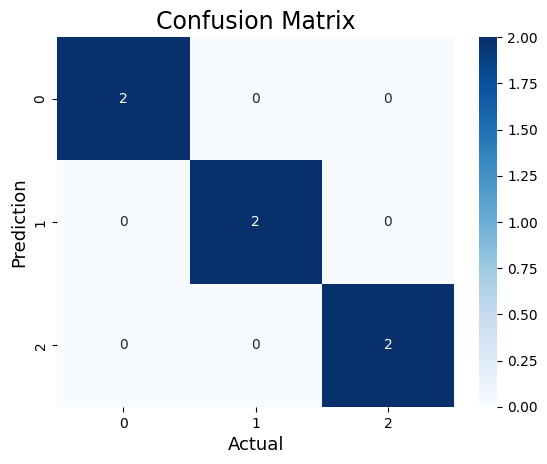

Accuracy=1.0; Precision=1.0; Recall=1.0; F1=1.0


In [27]:
classification_model_metrics(resnet, classes, val_dataloader, device)

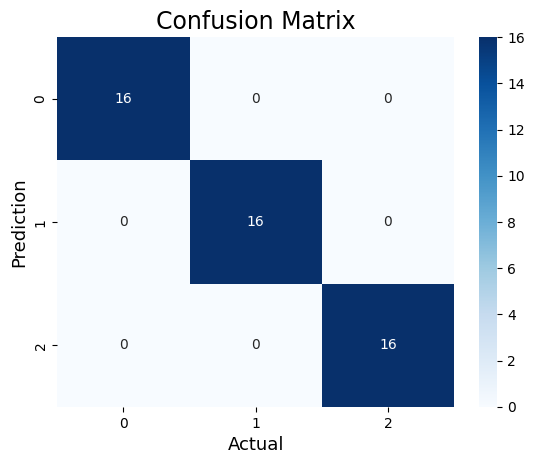

Accuracy=1.0; Precision=1.0; Recall=1.0; F1=1.0


In [28]:
classification_model_metrics(resnet, classes, train_dataloader, device)

In [ ]:
# Load best model state

# PATH = ""
# loaded_path = torch.load(PATH)
# model = torchvision.models.video.r3d_18()
# model.fc = nn.Linear(num_ftrs, n_class)
# model.load_state_dict(loaded_path['model_state_dict'])
# model.to(device)